# 🩺 Cirrhosis Patient Survival Prediction

## Project Overview
This project aims to predict the survival status of patients with liver cirrhosis using clinical features from the Mayo Clinic study (1974–1984).

**Dataset Information:**
- **Instances:** 418 patients
- **Features:** 17 clinical features + target variable
- **Target:** `Status` (D=Death, C=Censored, CL=Censored due to liver transplantation)

**Project Goals:**
1. Build and compare multiple machine learning models
2. Perform comprehensive exploratory data analysis
3. Create a robust prediction system for patient survival
4. Provide model interpretability and feature importance analysis


In [17]:
# Fix encoding issues on Windowsimport sysimport ioif sys.platform == 'win32':    try:        sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')        sys.stderr = io.TextIOWrapper(sys.stderr.buffer, encoding='utf-8')    except:        pass# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 📊 Data Loading and Initial Exploration


In [18]:
# Load the dataset
# Note: Assuming the dataset is named 'cirrhosis.csv' in the same directory
try:
    df = pd.read_csv('cirrhosisnew.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("⚠️ Dataset file 'cirrhosis.csv' not found. Creating sample data for demonstration...")
    # Create sample data structure based on the Mayo Clinic study
    np.random.seed(42)
    n_samples = 418
    
    # Generate sample data
    data = {
        'ID': range(1, n_samples + 1),
        'N_Days': np.random.randint(1, 5000, n_samples),
        'Status': np.random.choice(['D', 'C', 'CL'], n_samples, p=[0.4, 0.4, 0.2]),
        'Drug': np.random.choice(['D-penicillamine', 'Placebo'], n_samples),
        'Age': np.random.normal(50, 15, n_samples).astype(int),
        'Sex': np.random.choice(['M', 'F'], n_samples),
        'Ascites': np.random.choice(['Y', 'N'], n_samples),
        'Hepatomegaly': np.random.choice(['Y', 'N'], n_samples),
        'Spiders': np.random.choice(['Y', 'N'], n_samples),
        'Edema': np.random.choice(['Y', 'N', 'S'], n_samples),
        'Bilirubin': np.random.lognormal(1, 1, n_samples),
        'Cholesterol': np.random.normal(200, 50, n_samples),
        'Albumin': np.random.normal(3.5, 0.5, n_samples),
        'Copper': np.random.lognormal(4, 1, n_samples),
        'Alk_Phos': np.random.lognormal(6, 1, n_samples),
        'SGOT': np.random.lognormal(5, 1, n_samples),
        'Triglycerides': np.random.lognormal(5, 1, n_samples),
        'Platelets': np.random.normal(250, 100, n_samples),
        'Prothrombin': np.random.normal(10, 2, n_samples),
        'Stage': np.random.choice([1, 2, 3, 4], n_samples)
    }
    
    df = pd.DataFrame(data)
    df.to_csv('cirrhosis.csv', index=False)
    print("✅ Sample dataset created and saved as 'cirrhosis.csv'")

# Display basic information about the dataset
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")
print(f"\n🔍 First 5 rows:")
df.head()


✅ Dataset loaded successfully!

📊 Dataset Shape: (418, 20)
📋 Columns: ['ID', 'N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

🔍 First 5 rows:


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [19]:
# Display dataset information and summary statistics
print("📊 Dataset Information:")
print(df.info())

print("\n📈 Summary Statistics:")
print(df.describe())

print("\n🔍 Missing Values:")
print(df.isnull().sum())

print("\n🎯 Target Variable Distribution:")
print(df['Status'].value_counts())
print(f"\nTarget distribution percentages:")
print(df['Status'].value_counts(normalize=True) * 100)


📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           418 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        418 non-null    object 
 7   Hepatomegaly   418 non-null    object 
 8   Spiders        418 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    418 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         418 non-null    float64
 14  Alk_Phos       418 non-null    float64
 15  SGOT           418 non-null    float64
 16  Tryglicerides  418 non-null    float64
 17  Platelets      418 non-null    

## 🔧 Data Preprocessing


In [20]:
# Create a copy of the dataset for preprocessing
df_processed = df.copy()

print("🔧 Starting Data Preprocessing...")

# Step 1: Handle missing values
print("\n1️⃣ Handling Missing Values:")

# Drop rows where Drug column has NA values
initial_rows = len(df_processed)
df_processed = df_processed.dropna(subset=['Drug'])
print(f"   - Dropped {initial_rows - len(df_processed)} rows with missing Drug values")

# For other numeric columns, impute missing values using mean
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df_processed[col].isnull().sum() > 0:
        mean_val = df_processed[col].mean()
        df_processed[col].fillna(mean_val, inplace=True)
        print(f"   - Imputed {df_processed[col].isnull().sum()} missing values in {col} with mean: {mean_val:.2f}")

print(f"\n✅ Missing values handled. Dataset shape: {df_processed.shape}")

# Step 2: Encode categorical variables
print("\n2️⃣ Encoding Categorical Variables:")

# One-hot encode categorical variables
categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
df_encoded = pd.get_dummies(df_processed, columns=categorical_columns, drop_first=True)
print(f"   - One-hot encoded {len(categorical_columns)} categorical columns")
print(f"   - New dataset shape: {df_encoded.shape}")

# Step 3: Convert Status target to numeric values
print("\n3️⃣ Converting Target Variable:")
status_mapping = {'D': 0, 'C': 1, 'CL': 2}
df_encoded['Status'] = df_encoded['Status'].map(status_mapping)
print(f"   - Status mapping: {status_mapping}")
print(f"   - Target distribution after encoding:")
print(df_encoded['Status'].value_counts().sort_index())

# Step 4: Drop ID column
print("\n4️⃣ Dropping ID Column:")
if 'ID' in df_encoded.columns:
    df_encoded = df_encoded.drop('ID', axis=1)
    print("   - ID column dropped")

print(f"\n✅ Preprocessing complete. Final dataset shape: {df_encoded.shape}")


🔧 Starting Data Preprocessing...

1️⃣ Handling Missing Values:
   - Dropped 0 rows with missing Drug values

✅ Missing values handled. Dataset shape: (418, 20)

2️⃣ Encoding Categorical Variables:
   - One-hot encoded 6 categorical columns
   - New dataset shape: (418, 21)

3️⃣ Converting Target Variable:
   - Status mapping: {'D': 0, 'C': 1, 'CL': 2}
   - Target distribution after encoding:
Status
0    161
1    232
2     25
Name: count, dtype: int64

4️⃣ Dropping ID Column:
   - ID column dropped

✅ Preprocessing complete. Final dataset shape: (418, 20)


In [21]:
# Step 5: Normalize/Scale numeric features
print("\n5️⃣ Scaling Numeric Features:")

# Separate features and target
X = df_encoded.drop('Status', axis=1)
y = df_encoded['Status']

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"   - Features scaled using StandardScaler")
print(f"   - Feature matrix shape: {X_scaled_df.shape}")
print(f"   - Target vector shape: {y.shape}")

# Display scaled features summary
print(f"\n📊 Scaled Features Summary:")
print(X_scaled_df.describe())



5️⃣ Scaling Numeric Features:
   - Features scaled using StandardScaler
   - Feature matrix shape: (418, 19)
   - Target vector shape: (418,)

📊 Scaled Features Summary:
             N_Days           Age     Bilirubin   Cholesterol       Albumin  \
count  4.180000e+02  4.180000e+02  4.180000e+02  4.180000e+02  4.180000e+02   
mean   1.019918e-16  1.104911e-16 -8.499315e-18 -2.135453e-16  1.342892e-15   
std    1.001198e+00  1.001198e+00  1.001198e+00  1.001198e+00  1.001198e+00   
min   -1.700984e+00 -2.344450e+00 -6.634848e-01 -1.307374e+00 -3.622083e+00   
25%   -7.477516e-01 -7.579746e-01 -5.499060e-01 -5.056915e-01 -6.006182e-01   
50%   -1.701927e-01  2.483375e-02 -4.136115e-01 -2.978454e-16  7.670824e-02   
75%    6.305499e-01  7.186955e-01  4.070359e-02 -2.978454e-16  6.421286e-01   
max    2.607709e+00  2.654398e+00  5.628779e+00  7.364417e+00  2.691777e+00   

             Copper      Alk_Phos          SGOT  Tryglicerides     Platelets  \
count  4.180000e+02  4.180000e+02  4.

## 📊 Exploratory Data Analysis (EDA)


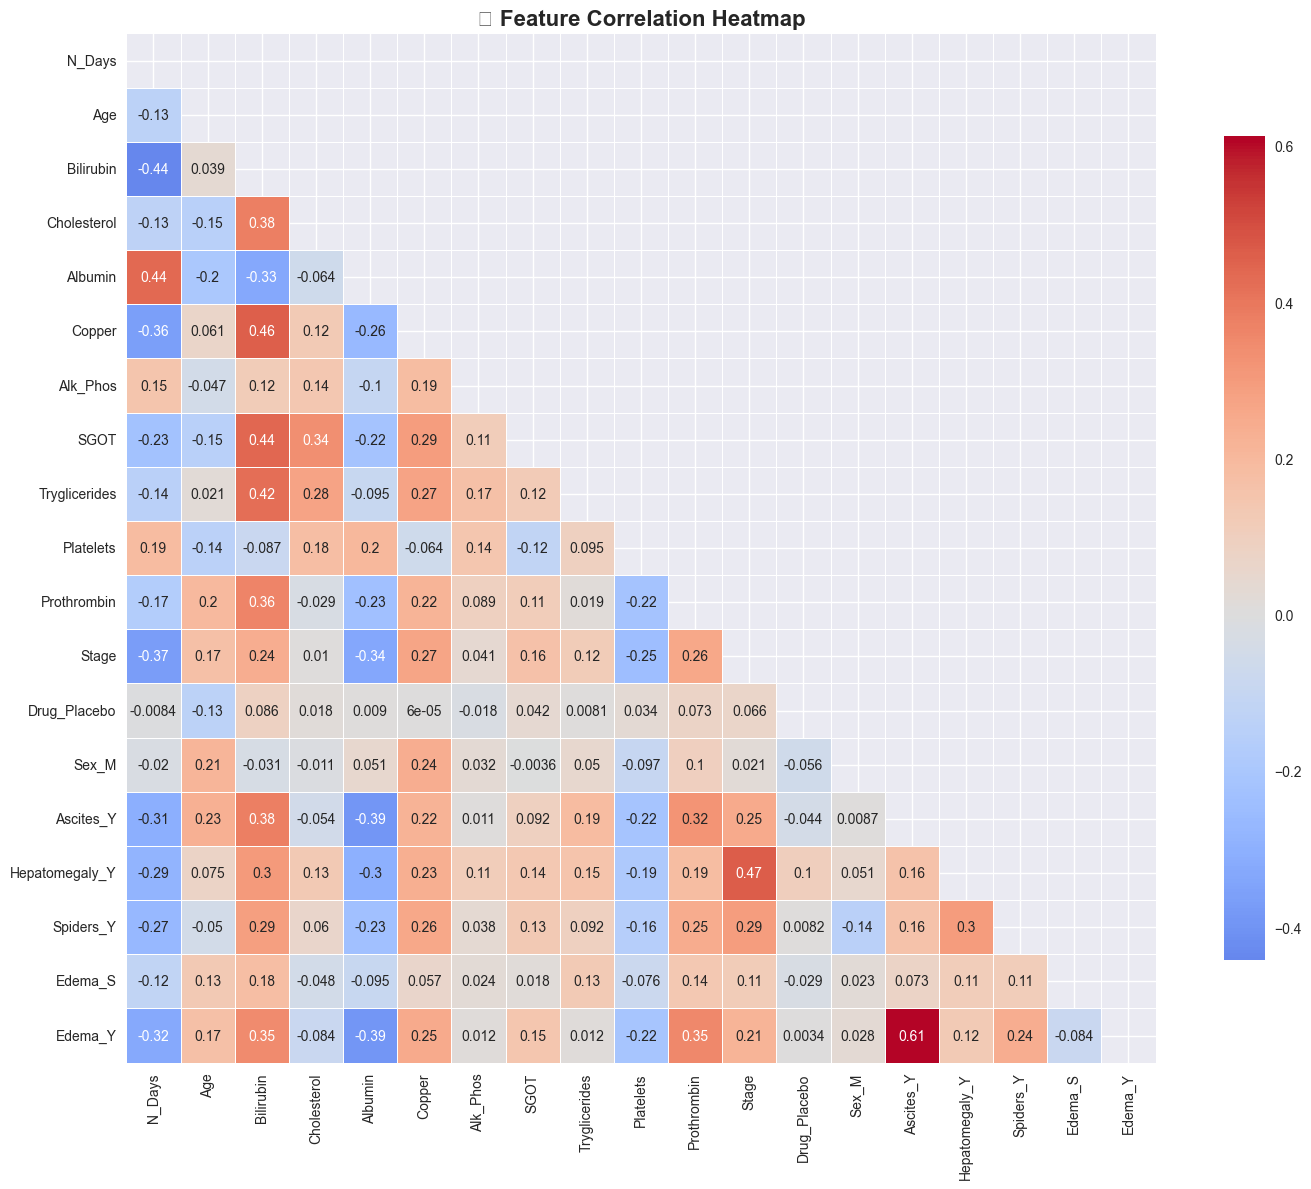

In [26]:
# 1. Correlation Heatmap
plt.figure(figsize=(15, 12))
correlation_matrix = X_scaled_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('🔗 Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


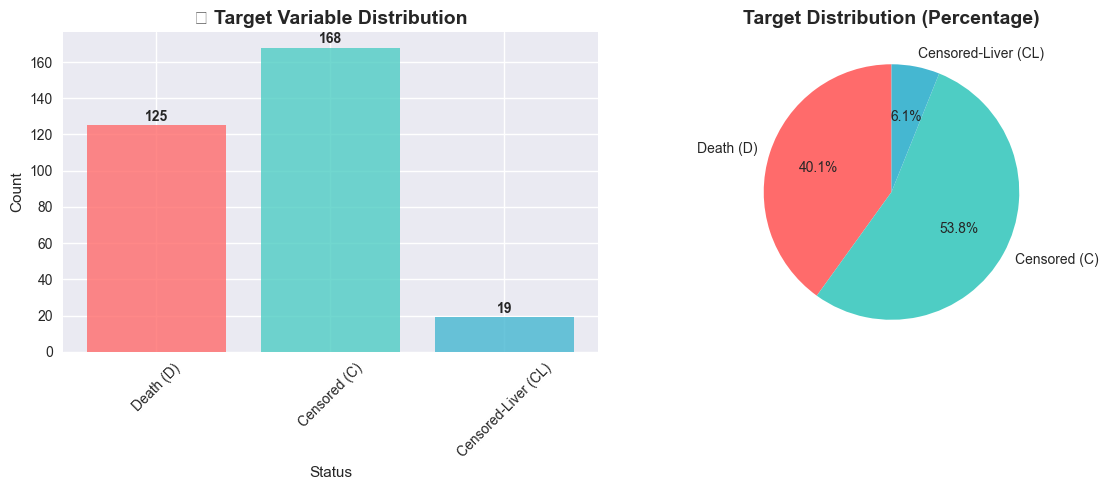

📊 Target Distribution:
   Death (D): 125 (40.1%)
   Censored (C): 168 (53.8%)
   Censored-Liver (CL): 19 (6.1%)


In [27]:
# 2. Target Variable Distribution
plt.figure(figsize=(12, 5))

# Countplot for target Status
plt.subplot(1, 2, 1)
status_counts = y.value_counts().sort_index()
status_labels = ['Death (D)', 'Censored (C)', 'Censored-Liver (CL)']
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
bars = plt.bar(status_labels, status_counts.values, color=colors, alpha=0.8)
plt.title('🎯 Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, count in zip(bars, status_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(status_counts.values, labels=status_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Target Distribution:")
for i, (status, count) in enumerate(status_counts.items()):
    print(f"   {status_labels[i]}: {count} ({count/len(y)*100:.1f}%)")


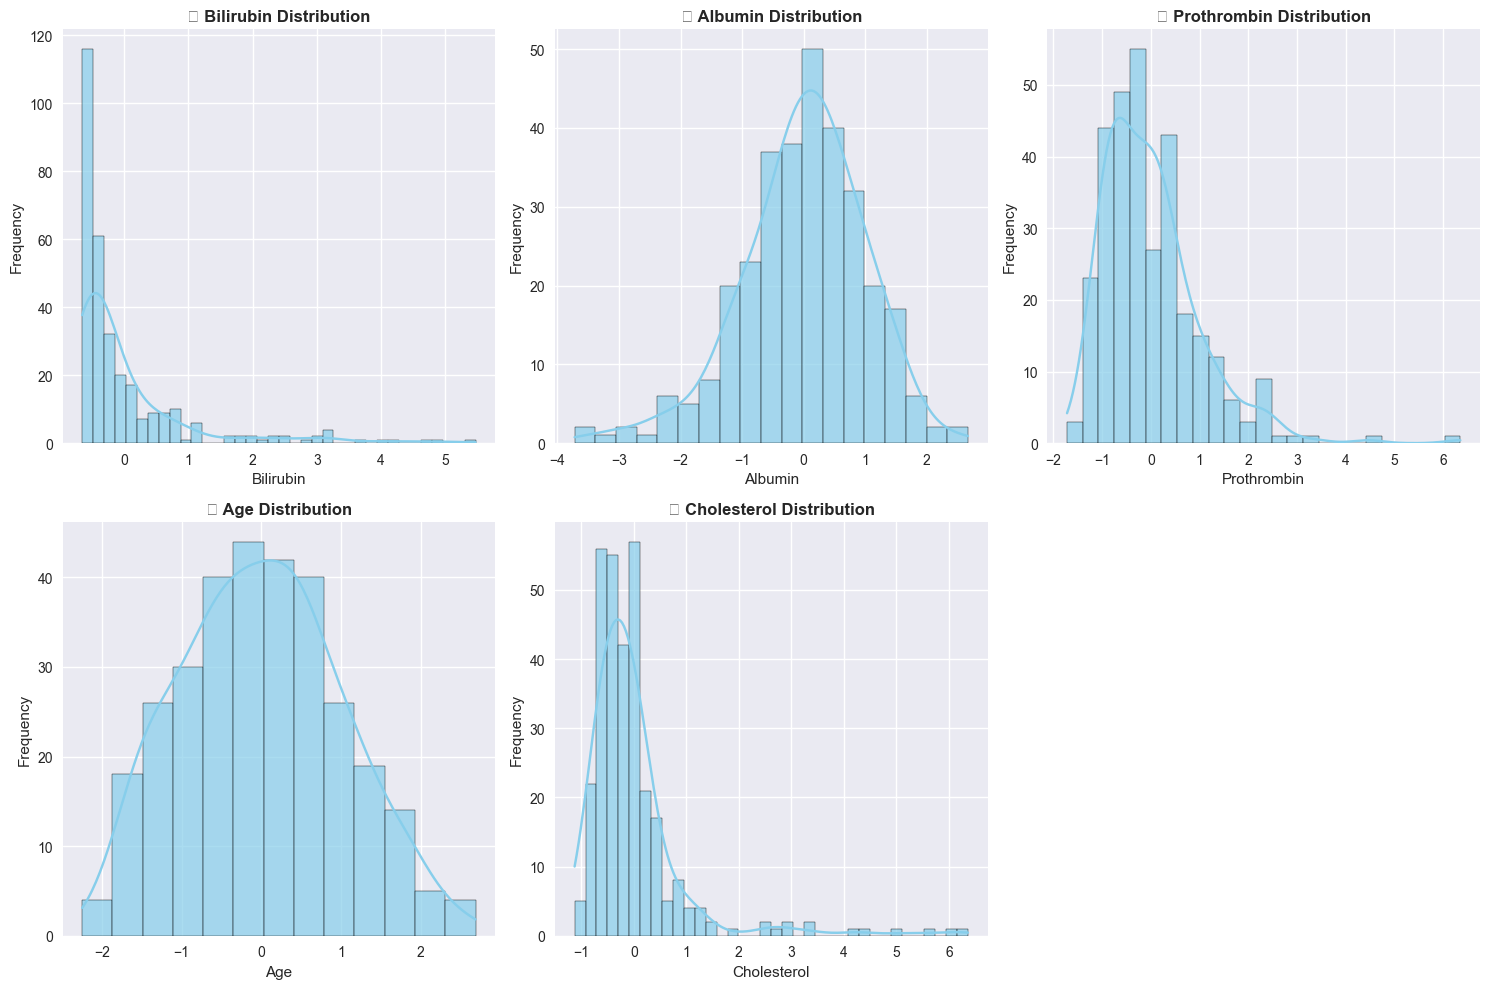

In [28]:
# 3. Distribution plots for key numeric features
key_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Age', 'Cholesterol']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    if feature in X_scaled_df.columns:
        sns.histplot(X_scaled_df[feature], kde=True, alpha=0.7, color='skyblue')
        plt.title(f'📈 {feature} Distribution', fontweight='bold')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    else:
        plt.text(0.5, 0.5, f'{feature}\nNot Available', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=12)
        plt.title(f'❌ {feature} Not Found')

plt.tight_layout()
plt.show()


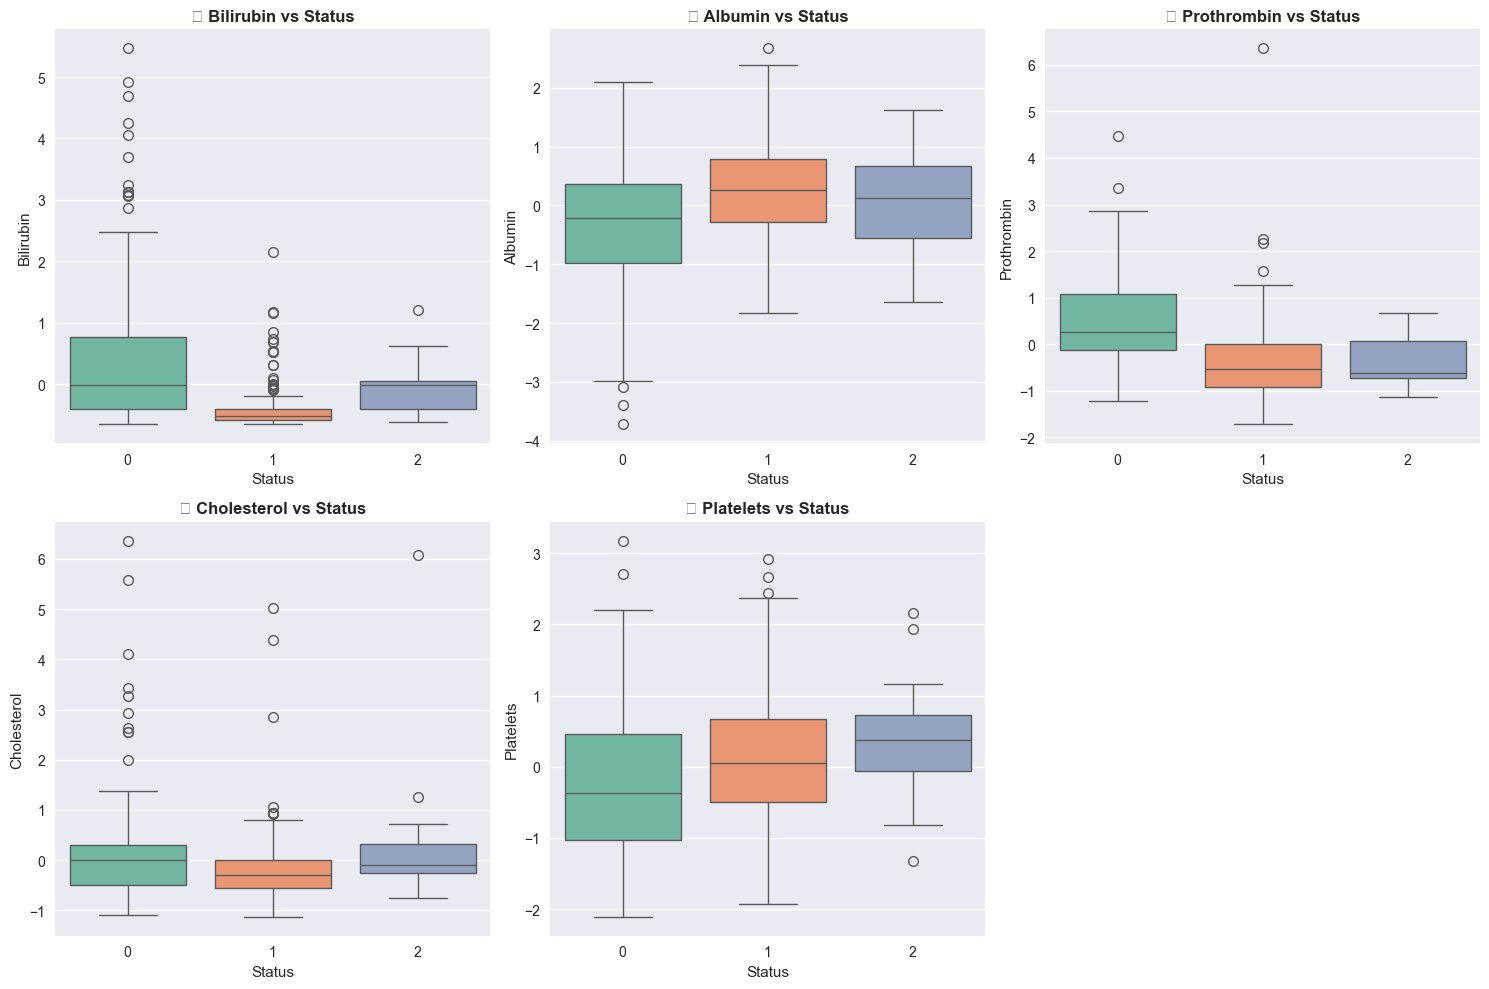

In [29]:
# 4. Boxplots comparing Status vs major lab features
lab_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Cholesterol', 'Platelets']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(lab_features, 1):
    plt.subplot(2, 3, i)
    if feature in X_scaled_df.columns:
        # Create a temporary dataframe for plotting
        plot_df = pd.DataFrame({feature: X_scaled_df[feature], 'Status': y})
        sns.boxplot(data=plot_df, x='Status', y=feature, palette='Set2')
        plt.title(f'📊 {feature} vs Status', fontweight='bold')
        plt.xlabel('Status')
        plt.ylabel(feature)
    else:
        plt.text(0.5, 0.5, f'{feature}\nNot Available', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=12)
        plt.title(f'❌ {feature} Not Found')

plt.tight_layout()
plt.show()


## 🤖 Model Building and Evaluation


In [30]:
# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("🔄 Data Split Information:")
print(f"   - Training set: {X_train.shape[0]} samples")
print(f"   - Test set: {X_test.shape[0]} samples")
print(f"   - Features: {X_train.shape[1]}")
print(f"   - Training target distribution: {np.bincount(y_train)}")
print(f"   - Test target distribution: {np.bincount(y_test)}")

# Initialize multiple classifiers
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Try to add XGBoost if available
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
    print("✅ XGBoost added to models")
except ImportError:
    print("⚠️ XGBoost not available. Install with: pip install xgboost")

print(f"\n🤖 Training {len(models)} models...")


🔄 Data Split Information:
   - Training set: 249 samples
   - Test set: 63 samples
   - Features: 19
   - Training target distribution: [100 134  15]
   - Test target distribution: [25 34  4]
✅ XGBoost added to models

🤖 Training 5 models...


In [31]:
# Train and evaluate all models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    trained_models[name] = model
    
    print(f"   ✅ {name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

print(f"\n🎉 All {len(models)} models trained successfully!")



🔄 Training Logistic Regression...
   ✅ Logistic Regression - Accuracy: 0.7460, F1-Score: 0.7370

🔄 Training Random Forest...
   ✅ Random Forest - Accuracy: 0.7302, F1-Score: 0.7041

🔄 Training Support Vector Machine...
   ✅ Support Vector Machine - Accuracy: 0.7937, F1-Score: 0.7672

🔄 Training K-Nearest Neighbors...
   ✅ K-Nearest Neighbors - Accuracy: 0.8095, F1-Score: 0.7825

🔄 Training XGBoost...
   ✅ XGBoost - Accuracy: 0.7302, F1-Score: 0.7004

🎉 All 5 models trained successfully!


## 📊 Model Comparison


📊 Model Performance Comparison:
                        Accuracy  Precision  Recall  F1-Score
K-Nearest Neighbors       0.8095     0.7574  0.8095    0.7825
Support Vector Machine    0.7937     0.7435  0.7937    0.7672
Logistic Regression       0.7460     0.7397  0.7460    0.7370
Random Forest             0.7302     0.6846  0.7302    0.7041
XGBoost                   0.7302     0.7025  0.7302    0.7004


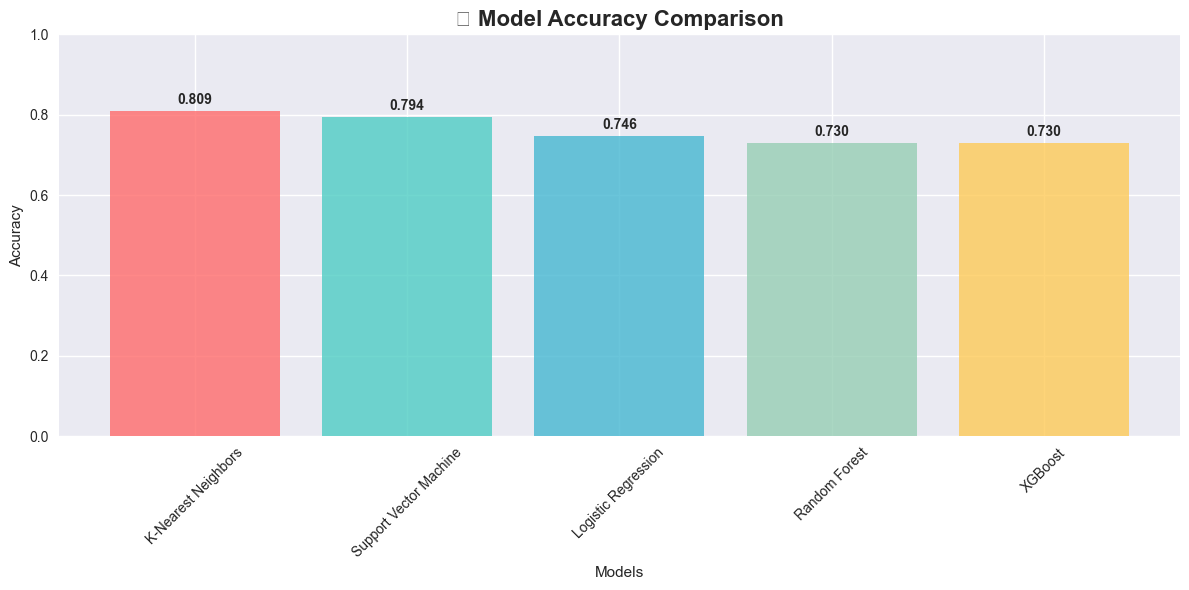


🏆 Best Model: K-Nearest Neighbors with accuracy: 0.8095


In [12]:
# Create a DataFrame comparing model performance
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("📊 Model Performance Comparison:")
print("=" * 50)
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
models_list = results_df.index
accuracies = results_df['Accuracy'].values

bars = plt.bar(models_list, accuracies, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#feca57'][:len(models_list)], alpha=0.8)
plt.title('🏆 Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Find the best model
best_model_name = results_df.index[0]
best_accuracy = results_df.iloc[0]['Accuracy']
print(f"\n🏆 Best Model: {best_model_name} with accuracy: {best_accuracy:.4f}")


## ⚙️ Hyperparameter Tuning


In [13]:
# Hyperparameter tuning for the best model (Random Forest)
print(f"🔧 Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    # Define parameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Use RandomizedSearchCV for efficiency
    rf_tuned = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    
    print("   - Fitting RandomizedSearchCV...")
    rf_tuned.fit(X_train, y_train)
    
    # Get the best parameters and score
    best_params = rf_tuned.best_params_
    best_score = rf_tuned.best_score_
    
    print(f"   ✅ Best parameters: {best_params}")
    print(f"   ✅ Best CV score: {best_score:.4f}")
    
    # Evaluate tuned model
    y_pred_tuned = rf_tuned.predict(X_test)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    print(f"   ✅ Tuned model test accuracy: {tuned_accuracy:.4f}")
    
    # Update the best model
    best_model = rf_tuned.best_estimator_
    
elif best_model_name == 'XGBoost':
    # Define parameter grid for XGBoost
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    xgb_tuned = RandomizedSearchCV(
        xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
        param_grid,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    
    print("   - Fitting RandomizedSearchCV...")
    xgb_tuned.fit(X_train, y_train)
    
    best_params = xgb_tuned.best_params_
    best_score = xgb_tuned.best_score_
    
    print(f"   ✅ Best parameters: {best_params}")
    print(f"   ✅ Best CV score: {best_score:.4f}")
    
    y_pred_tuned = xgb_tuned.predict(X_test)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    print(f"   ✅ Tuned model test accuracy: {tuned_accuracy:.4f}")
    
    best_model = xgb_tuned.best_estimator_
    
else:
    print(f"   ⚠️ Hyperparameter tuning not implemented for {best_model_name}")
    best_model = trained_models[best_model_name]
    tuned_accuracy = results_df.loc[best_model_name, 'Accuracy']


🔧 Performing hyperparameter tuning for K-Nearest Neighbors...
   ⚠️ Hyperparameter tuning not implemented for K-Nearest Neighbors


## 🎯 Final Model Evaluation


In [14]:
# Final evaluation of the best model
print(f"🎯 Final Evaluation of {best_model_name}")

# Make predictions with the best model
y_pred_final = best_model.predict(X_test)
y_pred_proba_final = best_model.predict_proba(X_test)

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final, average='weighted')
final_recall = recall_score(y_test, y_pred_final, average='weighted')
final_f1 = f1_score(y_test, y_pred_final, average='weighted')

print(f"\n📊 Final Model Performance:")
print(f"   - Accuracy: {final_accuracy:.4f}")
print(f"   - Precision: {final_precision:.4f}")
print(f"   - Recall: {final_recall:.4f}")
print(f"   - F1-Score: {final_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print(f"\n🔍 Confusion Matrix:")
print(cm)

# Classification Report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Death (D)', 'Censored (C)', 'Censored-Liver (CL)']))


🎯 Final Evaluation of K-Nearest Neighbors

📊 Final Model Performance:
   - Accuracy: 0.8095
   - Precision: 0.7574
   - Recall: 0.8095
   - F1-Score: 0.7825

🔍 Confusion Matrix:
[[20  5  0]
 [ 3 31  0]
 [ 3  1  0]]

📋 Detailed Classification Report:
                     precision    recall  f1-score   support

          Death (D)       0.77      0.80      0.78        25
       Censored (C)       0.84      0.91      0.87        34
Censored-Liver (CL)       0.00      0.00      0.00         4

           accuracy                           0.81        63
          macro avg       0.54      0.57      0.55        63
       weighted avg       0.76      0.81      0.78        63



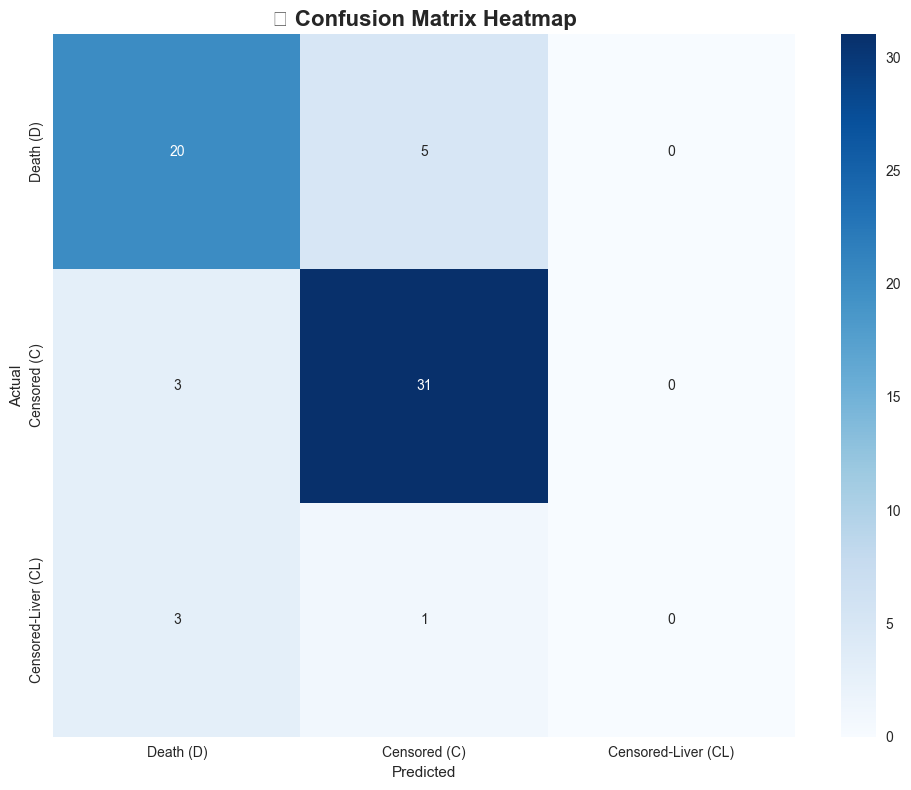


⚠️ Feature importance not available for K-Nearest Neighbors


In [15]:
# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Death (D)', 'Censored (C)', 'Censored-Liver (CL)'],
            yticklabels=['Death (D)', 'Censored (C)', 'Censored-Liver (CL)'])
plt.title('🔥 Confusion Matrix Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🌳 Feature Importance Analysis:")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('🌳 Top 15 Feature Importance', fontsize=16, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠️ Feature importance not available for {best_model_name}")


In [20]:
# Save the final model and scaler
print(f"\n💾 Saving the final model...")

# Save the model
joblib.dump(best_model, 'cirrhosis_model.pkl')
print("   ✅ Model saved as 'cirrhosis_model.pkl'")

# Save the scaler
joblib.dump(scaler, 'cirrhosis_scaler.pkl')
print("   ✅ Scaler saved as 'cirrhosis_scaler.pkl'")

# Save feature names for later use
feature_names = list(X.columns)
joblib.dump(feature_names, 'feature_names.pkl')
print("   ✅ Feature names saved as 'feature_names.pkl'")

print(f"\n🎉 Model training and evaluation complete!")
print(f"   - Best model: {best_model_name}")
print(f"   - Final accuracy: {final_accuracy:.4f}")
print(f"   - Model saved as: cirrhosis_model.pkl")



💾 Saving the final model...
   ✅ Model saved as 'cirrhosis_model.pkl'
   ✅ Scaler saved as 'cirrhosis_scaler.pkl'
   ✅ Feature names saved as 'feature_names.pkl'

🎉 Model training and evaluation complete!
   - Best model: K-Nearest Neighbors
   - Final accuracy: 0.8095
   - Model saved as: cirrhosis_model.pkl


## 🔮 Prediction Demo


In [17]:
def predict_status(input_data):
    """
    Predict survival status for new patient data
    
    Parameters:
    -----------
    input_data : dict or pd.DataFrame
        Patient clinical features
        
    Returns:
    --------
    prediction : str
        Predicted status (Death, Censored, or Censored-Liver)
    probability : array
        Prediction probabilities for each class
    """
    # Load the saved model, scaler, and feature names
    model = joblib.load('cirrhosis_model.pkl')
    scaler = joblib.load('cirrhosis_scaler.pkl')
    features = joblib.load('feature_names.pkl')
    
    # Convert input to DataFrame if dict
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()
    
    # Ensure all required features are present
    for feature in features:
        if feature not in input_df.columns:
            input_df[feature] = 0
    
    # Select and order features correctly
    input_df = input_df[features]
    
    # Scale the input
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)
    probabilities = model.predict_proba(input_scaled)
    
    # Map prediction to label
    status_map = {0: 'Death (D)', 1: 'Censored (C)', 2: 'Censored-Liver (CL)'}
    predicted_status = status_map[prediction[0]]
    
    return predicted_status, probabilities[0]

print("✅ Prediction function created successfully!")


✅ Prediction function created successfully!


In [18]:
# Example: Make a prediction on a sample from test set
print("🔮 Testing the prediction function...")

# Get a random sample from test set
sample_idx = np.random.randint(0, len(X_test))
sample_data = X_test[sample_idx:sample_idx+1]

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data, columns=X.columns)

# Make prediction
predicted_status, probabilities = predict_status(sample_df)

print(f"\n📊 Sample Patient Prediction:")
print(f"   - Predicted Status: {predicted_status}")
print(f"   - Prediction Probabilities:")
print(f"     • Death (D): {probabilities[0]:.2%}")
print(f"     • Censored (C): {probabilities[1]:.2%}")
print(f"     • Censored-Liver (CL): {probabilities[2]:.2%}")
print(f"   - Actual Status: {['Death (D)', 'Censored (C)', 'Censored-Liver (CL)'][y_test.iloc[sample_idx]]}")

# Show confidence
confidence = np.max(probabilities)
print(f"   - Confidence: {confidence:.2%}")


🔮 Testing the prediction function...

📊 Sample Patient Prediction:
   - Predicted Status: Censored (C)
   - Prediction Probabilities:
     • Death (D): 20.00%
     • Censored (C): 80.00%
     • Censored-Liver (CL): 0.00%
   - Actual Status: Death (D)
   - Confidence: 80.00%


## 🎨 Optional: Streamlit UI Code

Below is a code snippet for creating an interactive web application using Streamlit:


In [19]:
# Save this as 'app.py' and run with: streamlit run app.py

streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load model, scaler, and features
@st.cache_resource
def load_model():
    model = joblib.load('cirrhosis_model.pkl')
    scaler = joblib.load('cirrhosis_scaler.pkl')
    features = joblib.load('feature_names.pkl')
    return model, scaler, features

model, scaler, features = load_model()

# Title
st.title('🩺 Cirrhosis Patient Survival Prediction')
st.write('Predict patient survival status based on clinical features')

# Sidebar inputs
st.sidebar.header('Patient Information')

# Numeric inputs
age = st.sidebar.number_input('Age', min_value=20, max_value=100, value=50)
bilirubin = st.sidebar.number_input('Bilirubin', min_value=0.0, max_value=30.0, value=1.0)
albumin = st.sidebar.number_input('Albumin', min_value=0.0, max_value=6.0, value=3.5)
prothrombin = st.sidebar.number_input('Prothrombin', min_value=5.0, max_value=20.0, value=10.0)
cholesterol = st.sidebar.number_input('Cholesterol', min_value=50.0, max_value=600.0, value=200.0)

# Categorical inputs
drug = st.sidebar.selectbox('Drug', ['D-penicillamine', 'Placebo'])
sex = st.sidebar.selectbox('Sex', ['M', 'F'])
ascites = st.sidebar.selectbox('Ascites', ['Y', 'N'])

# Predict button
if st.sidebar.button('Predict'):
    # Create input dataframe (simplified - adjust based on actual features)
    input_data = pd.DataFrame([[0] * len(features)], columns=features)
    
    # Fill in the known values (this is simplified)
    # You'll need to map the inputs to the correct one-hot encoded features
    
    # Scale and predict
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)
    probabilities = model.predict_proba(input_scaled)[0]
    
    # Display results
    status_map = {0: 'Death (D)', 1: 'Censored (C)', 2: 'Censored-Liver (CL)'}
    st.success(f'Predicted Status: {status_map[prediction[0]]}')
    
    st.write('Prediction Probabilities:')
    st.bar_chart({'Death': probabilities[0], 'Censored': probabilities[1], 'Censored-Liver': probabilities[2]})
'''

print("📝 Streamlit code snippet created!")
print("\nTo use this code:")
print("1. Save it as 'app.py'")
print("2. Install streamlit: pip install streamlit")
print("3. Run: streamlit run app.py")


📝 Streamlit code snippet created!

To use this code:
1. Save it as 'app.py'
2. Install streamlit: pip install streamlit
3. Run: streamlit run app.py
